In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import ndimage
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score

from utils import *
from model_FCNN import generate_model

seed = 47
np.random.seed(seed)

Using TensorFlow backend.


In [61]:
from importlib import reload

import keras
reload(keras)
from keras import backend as K

import utils
reload(utils)
from utils import *

import model_FCNN
reload(model_FCNN)
from model_FCNN import generate_model

# Problem configuration

In [3]:
num_classes = 11
num_channel = 3

# K-fold validation (K=5)
n_training = 16
n_test = 4

idxs_training = list(range(1, 1+16))
idxs_test = list(range(17, 17+4))

patience = 5
model_filename = 'models/outrun_step_{}.h5'
csv_filename = 'log/outrun_step_{}.cvs'

nb_epoch = 40
validation_split = 0.20

class_mapper = {0:0}
class_mapper.update({ i+1:i for i in range(1, 1+10) })
class_mapper_inv = {0:0}
class_mapper_inv.update({ i:i+1 for i in range(1, 1+10) })

matrix_size = (160, 220, 48)

extraction_step = (3, 3, 3)
#extraction_step = (9, 9, 3)

segment_size = (27, 27, 21)
core_size = (9, 9, 3)

# Architecture

# 1. Initial segmentation

## 1.1 Read data

In [4]:
QSM_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
MAG_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
R2S_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
label_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
for i, case_idx in enumerate(idxs_training):
    QSM_train[i, :, :, :] = read_data(case_idx, 'QSM')
    MAG_train[i, :, :, :] = read_data(case_idx, 'MAG')
    R2S_train[i, :, :, :] = read_data(case_idx, 'R2S')
    label_train[i, :, :, :] = read_data(case_idx, 'label')

In [5]:
data_train = np.stack((QSM_train, MAG_train, R2S_train), axis = 1)

In [6]:
QSM_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
MAG_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
R2S_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
label_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
for i, case_idx in enumerate(idxs_test):
    QSM_test[i, :, :, :] = read_data(case_idx, 'QSM')
    MAG_test[i, :, :, :] = read_data(case_idx, 'MAG')
    R2S_test[i, :, :, :] = read_data(case_idx, 'R2S')
    label_test[i, :, :, :] = read_data(case_idx, 'label')

In [7]:
data_test = np.stack((QSM_test, MAG_test, R2S_test), axis = 1)

## 1.2 Pre-processing

In [8]:
## Intensity normalisation (zero mean and unit variance)
input_mean = 127.0
input_std = 128.0
data_train = (data_train - input_mean) / input_std
data_test = (data_test - input_mean) / input_std

# Map class label
tmp = np.copy(label_train)
for class_idx in class_mapper:
    label_train[tmp == class_idx] = class_mapper[class_idx]
tmp = np.copy(label_test)
for class_idx in class_mapper:
    label_test[tmp == class_idx] = class_mapper[class_idx]
del tmp

In [8]:
label_train.max()

10.0

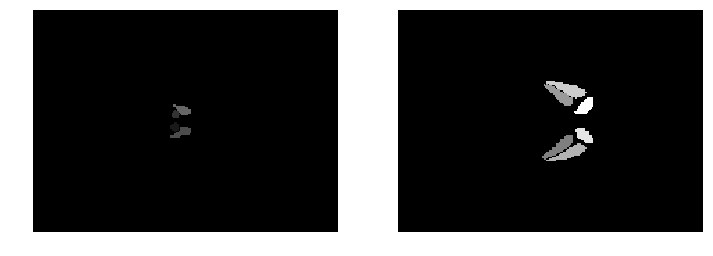

In [9]:
plots(np.squeeze(label_train[0,:,:,[29,25]]), scale = (0, 10))

## 1.3 Data preparation

In [15]:
x_train, y_train = build_set(data_train, label_train, extraction_step, segment_size, core_size)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


((10850, 3, 27, 27, 21), (10850, 243, 11))

## 1.4 Configure callbacks

In [19]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

# Early stopping for reducing over-fitting risk
stopper = EarlyStopping(patience=patience, monitor='val_categorical_accuracy')

# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('1'),
    monitor='val_categorical_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')

callbacks = [checkpointer, csv_logger, stopper]
#callbacks = [checkpointer, csv_logger]

## 1.5 Training

In [20]:
# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

K.set_value(model.optimizer.lr, 1e-3)

model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 8680 samples, validate on 2170 samples
Epoch 1/40
8680/8680 [==============================] - 54s 6ms/step - loss: 0.6022 - categorical_accuracy: 0.8213 - val_loss: 0.5360 - val_categorical_accuracy: 0.8416
Epoch 2/40
8680/8680 [==============================] - 53s 6ms/step - loss: 0.1988 - categorical_accuracy: 0.9240 - val_loss: 0.3791 - val_categorical_accuracy: 0.8804
Epoch 3/40
8680/8680 [==============================] - 53s 6ms/step - loss: 0.1201 - categorical_accuracy: 0.9506 - val_loss: 0.4850 - val_categorical_accuracy: 0.8776
Epoch 4/40
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0951 - categorical_accuracy: 0.9609 - val_loss: 0.5189 - val_categorical_accuracy: 0.8802
Epoch 5/40
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0650 - categorical_accuracy: 0.9732 - val_loss: 0.6099 - val_categorical_accuracy: 0.8867
Epoch 6/40
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0521 - categorical_accuracy:

In [21]:
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-4)

model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

Train on 8680 samples, validate on 2170 samples
Epoch 1/40
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0110 - categorical_accuracy: 0.9962 - val_loss: 1.0005 - val_categorical_accuracy: 0.8915
Epoch 2/40
8680/8680 [==============================] - 53s 6ms/step - loss: 0.0041 - categorical_accuracy: 0.9988 - val_loss: 1.1298 - val_categorical_accuracy: 0.8914
Epoch 3/40
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0021 - categorical_accuracy: 0.9995 - val_loss: 1.2402 - val_categorical_accuracy: 0.8904
Epoch 4/40
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0010 - categorical_accuracy: 0.9998 - val_loss: 1.3051 - val_categorical_accuracy: 0.8903
Epoch 5/40
8680/8680 [==============================] - 54s 6ms/step - loss: 6.0801e-04 - categorical_accuracy: 0.9999 - val_loss: 1.3650 - val_categorical_accuracy: 0.8898
Epoch 6/40
8680/8680 [==============================] - 54s 6ms/step - loss: 2.7818e-04 - categorical_a

In [22]:
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-5)

model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

Train on 8680 samples, validate on 2170 samples
Epoch 1/20
8680/8680 [==============================] - 52s 6ms/step - loss: 0.0176 - categorical_accuracy: 0.9937 - val_loss: 0.7717 - val_categorical_accuracy: 0.8934
Epoch 2/20
8680/8680 [==============================] - 53s 6ms/step - loss: 0.0109 - categorical_accuracy: 0.9963 - val_loss: 0.8553 - val_categorical_accuracy: 0.8931
Epoch 3/20
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0084 - categorical_accuracy: 0.9973 - val_loss: 0.9215 - val_categorical_accuracy: 0.8925
Epoch 4/20
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0067 - categorical_accuracy: 0.9978 - val_loss: 0.9851 - val_categorical_accuracy: 0.8919
Epoch 5/20
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0056 - categorical_accuracy: 0.9983 - val_loss: 1.0185 - val_categorical_accuracy: 0.8920
Epoch 6/20
8680/8680 [==============================] - 54s 6ms/step - loss: 0.0047 - categorical_accuracy:

In [ ]:
model.save_weights(model_filename.format(1))

## 1.6 Classification

In [23]:
from keras.models import load_model

# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format(1))

In [24]:
len_patch = extract_patches(read_data(1, 'QSM'), patch_shape=segment_size, extraction_step=(9, 9, 3)).shape[0]
len_patch

3300

In [25]:
segmentations_train = []

for i_case, case_idx in enumerate(idxs_training):

    print(case_idx)
    input_train = data_train[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_train[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations_train = segmentations_train + [segmentation]
    
segmentations_train = np.stack(segmentations_train, axis=0)

1
3300/3300 [==============================] - 3s 893us/step
2
3300/3300 [==============================] - 3s 828us/step
3
3300/3300 [==============================] - 3s 827us/step
4
3300/3300 [==============================] - 3s 830us/step
5
3300/3300 [==============================] - 3s 829us/step
6
3300/3300 [==============================] - 3s 829us/step
7
3300/3300 [==============================] - 3s 857us/step
8
3300/3300 [==============================] - 3s 835us/step
9
3300/3300 [==============================] - 3s 835us/step
10
3300/3300 [==============================] - 3s 841us/step
11
3300/3300 [==============================] - 3s 843us/step
12
3300/3300 [==============================] - 3s 859us/step
13
3300/3300 [==============================] - 3s 838us/step
14
3300/3300 [==============================] - 3s 834us/step
15
3300/3300 [==============================] - 3s 845us/step
16
3300/3300 [==============================] - 3s 841us/step


In [11]:
segmentations_train.max()

10.0

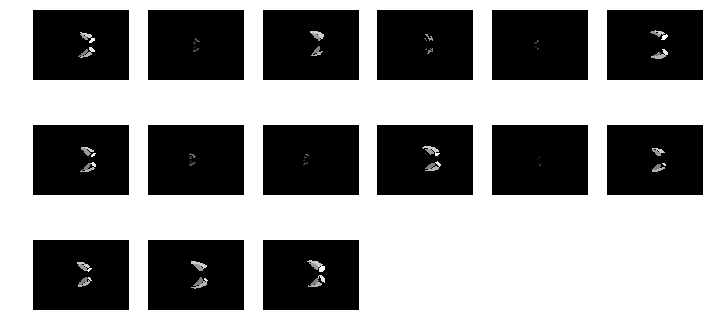

In [26]:
plots(np.squeeze(label_train[0:15,:,:,25]), rows=3, scale = (0, 10))

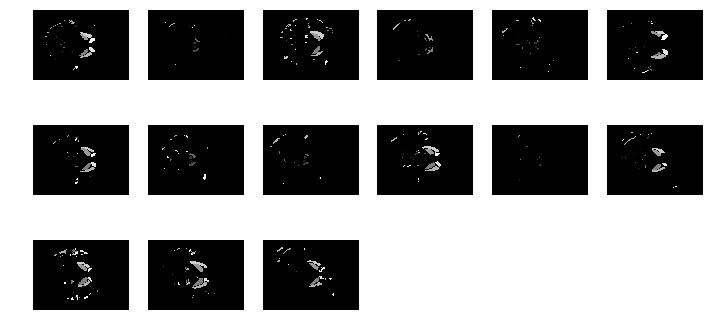

In [27]:
plots(np.squeeze(segmentations_train[0:15,:,:,25]), rows=3, scale = (0, 10))

## 1.7 Check false-positive

In [28]:
idx_fpos = (label_train == 0) & (segmentations_train != 0);

In [29]:
mask_fpos = np.zeros(label_train.shape, dtype=precision_global)
mask_fpos[idx_fpos == True] = 1

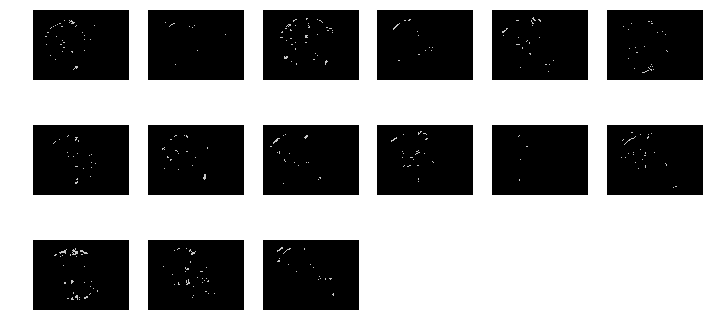

In [30]:
plots(200*(np.squeeze(mask_fpos[0:15,:,:,25])), rows=3)

# 2 Fine-tuning

## 2.2 Rebuild training dataset

In [31]:
del x_train, y_train

In [32]:
x_train, y_train = build_set(data_train, label_train, extraction_step, segment_size, core_size, mask_fpos)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


((79352, 3, 27, 27, 21), (79352, 243, 11))

In [33]:
save_array('tmp/x_train.bc', x_train)
save_array('tmp/y_train.bc', y_train)

In [4]:
x_train = load_array('tmp/x_train.bc')
y_train = load_array('tmp/y_train.bc')

## 2.3 Regenerate model

In [35]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

# Early stopping for reducing over-fitting risk
stopper = EarlyStopping(patience=patience, monitor='val_categorical_accuracy')

# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('2'),
    monitor='val_categorical_accuracy',
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')

callbacks = [checkpointer, csv_logger, stopper]
#callbacks = [checkpointer, csv_logger]

In [36]:
# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

# Load optimized weights
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-4)

# Start fine-tuning
model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 63481 samples, validate on 15871 samples
Epoch 1/40
63481/63481 [==============================] - 439s 7ms/step - loss: 0.0043 - categorical_accuracy: 0.9985 - val_loss: 0.1994 - val_categorical_accuracy: 0.9823
Epoch 2/40
63481/63481 [==============================] - 423s 7ms/step - loss: 0.0011 - categorical_accuracy: 0.9996 - val_loss: 0.2028 - val_categorical_accuracy: 0.9823
Epoch 3/40
63481/63481 [==============================] - 515s 8ms/step - loss: 7.6469e-04 - categorical_accuracy: 0.9998 - val_loss: 0.2122 - val_categorical_accuracy: 0.9824
Epoch 4/40
63481/63481 [==============================] - 580s 9ms/step - loss: 9.6305e-04 - categorical_accuracy: 0.9997 - val_loss: 0.2052 - val_categorical_accuracy: 0.9827
Epoch 5/40
63481/63481 [==============================] - 424s 7ms/step - loss: 5.6499e-04 - categorical_accuracy: 0.9998 - val_loss: 0.2214 - val_categorical_accuracy: 0.9822
Epoch 6/40
63481/63481 [==============================] - 451s 7ms/step - loss

In [37]:
model.load_weights(model_filename.format('2'))

K.set_value(model.optimizer.lr, 1e-5)

# Start fine-tuning
model.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

Train on 63481 samples, validate on 15871 samples
Epoch 1/20
63481/63481 [==============================] - 466s 7ms/step - loss: 2.3888e-05 - categorical_accuracy: 1.0000 - val_loss: 0.2141 - val_categorical_accuracy: 0.9830
Epoch 2/20
63481/63481 [==============================] - 394s 6ms/step - loss: 4.0586e-06 - categorical_accuracy: 1.0000 - val_loss: 0.2230 - val_categorical_accuracy: 0.9829
Epoch 3/20
63481/63481 [==============================] - 394s 6ms/step - loss: 1.4611e-06 - categorical_accuracy: 1.0000 - val_loss: 0.2274 - val_categorical_accuracy: 0.9829
Epoch 4/20
63481/63481 [==============================] - 401s 6ms/step - loss: 6.0525e-07 - categorical_accuracy: 1.0000 - val_loss: 0.2325 - val_categorical_accuracy: 0.9829
Epoch 5/20
63481/63481 [==============================] - 396s 6ms/step - loss: 2.9498e-07 - categorical_accuracy: 1.0000 - val_loss: 0.2362 - val_categorical_accuracy: 0.9829
Epoch 6/20
63481/63481 [==============================] - 402s 6ms/ste

In [ ]:
model.save_weights(model_filename.format('2'))

In [39]:
# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format('2'))

In [40]:
segmentations_test = []

for i_case, case_idx in enumerate(idxs_test):

    print(case_idx)
    input_test = data_test[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_test[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations_test = segmentations_test + [segmentation]
    
segmentations_test = np.stack(segmentations_test, axis=0)

17
3300/3300 [==============================] - 11s 3ms/step
18
3300/3300 [==============================] - 6s 2ms/step
19
3300/3300 [==============================] - 3s 890us/step
20
3300/3300 [==============================] - 3s 969us/step


In [41]:
segmentations_test.max()

10.0

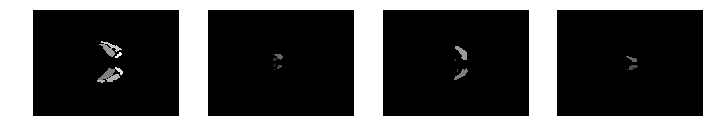

In [54]:
plots(np.squeeze(label_test[:,:,:,27]), rows=1, scale = (0, 10))

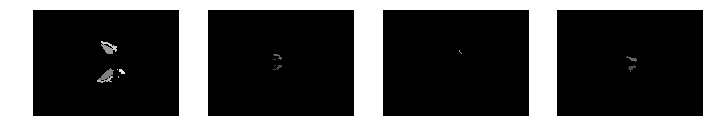

In [58]:
plots(np.squeeze(segmentations_test[:,:,:,27]), rows=1, scale = (0, 10))

# 3 Post-processing

## 3.1 Pick the largest connected component for each class

In [57]:
for i_case, case_idx in enumerate(idxs_test):
    segmentation = np.squeeze(segmentations_test[i_case,:,:,:]);
    tmp = np.zeros(segmentation.shape, dtype=segmentation.dtype)
    
    for class_idx in class_mapper_inv :
        mask = (segmentation == class_idx)
        
        if class_idx != 0 and mask.sum() > 0:
            labeled_mask, num_cc = ndimage.label(mask)
            largest_cc_mask = (labeled_mask == (np.bincount(labeled_mask.flat)[1:].argmax() + 1))
            
            tmp[largest_cc_mask == 1] = class_idx
        
    segmentations_test[i_case,:,:,:] = tmp

## 3.2 Save it 

In [62]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx)
    
    segmentation = np.squeeze(segmentations_test[i_case,:,:,:]);

    save_data(segmentation, case_idx, 'label')    

print("Done with Step 3")

17
18
19
20
Done with Step 3


## 3.3 Calculate metric 

In [63]:
def calc_dice(m1, m2):
    return 2*((m1==1) & (m2==1)).sum()/((m1==1).sum() + (m2==1).sum())

In [64]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    print('{:.4f}'.format(accuracy_score(label_test[i_case,:,:,:].flat, segmentations_test[i_case,:,:,:].flat)), end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(precision_score(label_test[i_case,:,:,:][mask], segmentations_test[i_case,:,:,:][mask], average='micro')), end='\t')
        else:
            print('N/A', end='\t')
    print()

17	0.9988	N/A	1.0000	1.0000	0.9720	0.9296	0.6794	0.9336	0.9334	0.8700	0.9301	0.7874	
18	0.9990	N/A	1.0000	0.9500	0.7755	0.8154	0.6910	0.7524	0.7576	0.7190	0.7517	0.7819	
19	0.9977	N/A	N/A	N/A	0.0000	N/A	1.0000	0.9333	N/A	N/A	0.6829	0.4444	
20	0.9989	N/A	1.0000	0.8929	0.8703	0.9265	0.9309	0.9305	0.7255	0.6312	0.7607	0.7665	


In [65]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(calc_dice((label_test[i_case,:,:,:]==class_idx).flat, (segmentations_test[i_case,:,:,:]==class_idx).flat)), end='\t')
        else:
            print(0, end='\t')
    print()

17	0	0.2264	0.0860	0.7704	0.6000	0.7805	0.8733	0.7515	0.7782	0.7788	0.7111	
18	0	0.5301	0.7917	0.8321	0.6817	0.7911	0.8272	0.7073	0.6230	0.7951	0.8172	
19	0	0	0	0.0000	0	0.0110	0.0461	0	0	0.4619	0.0656	
20	0	0.8519	0.7407	0.7630	0.8781	0.8235	0.7814	0.7325	0.7095	0.7534	0.7705	
